In [1]:
# pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from numpy import NaN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

import os
import yfinance as yf
warnings.filterwarnings("ignore")

from backtest_functions_v2 import *

In [3]:
def deepseek_absa_dataprocess(path):
  absa = pd.read_parquet(path)

  absa_date = absa[["date","tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa"]]
  absa_date = absa_date.groupby([absa_date['date'].dt.date], as_index=False).mean()

  absa_date['date'] = pd.to_datetime(absa_date['date'], format='%Y-%m-%d')

  # Extract only the date part (ignore the time)
  absa['date'] = absa['date'].dt.date
  absa_date['date'] = absa_date['date'].dt.date

  # Count the number of entries per day
  entries_per_day = absa.groupby('date').size()

  # Map the counts back to the original dataset
  absa['entries_per_day'] = absa['date'].map(entries_per_day)

  # Fill missing values with 0, if necessary
  absa_date['entries_per_day'] = absa['entries_per_day'].fillna(0)

  sentiment_columns = [
    'tanalysis_absa',
    'economy_absa',
    'regulation_absa',
    'technology_absa',
    'adoption_absa'
  ]

  # 2. Compute the average sentiment for each entry (row) by averaging across the sentiment columns
  absa_date['Average Sentiment'] = absa_date[sentiment_columns].mean(axis=1)
  absa_date['Average Sentiment'].fillna(0, inplace=True)
  absa_date['Sentiment_MA3'] = absa_date['Average Sentiment'].rolling(window=3, min_periods=1).mean()
  absa_date['Sentiment_MA7'] = absa_date['Average Sentiment'].rolling(window=7, min_periods=1).mean()
  absa_date['Sentiment_MA14'] = absa_date['Average Sentiment'].rolling(window=14, min_periods=1).mean()

  return absa_date


In [4]:
def MutualInfo(df):
  X = df.drop(["target","date"], axis=1)
  y = df["target"]
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores.sort_values(ascending=False, inplace=True)
  print(mi_scores)

In [5]:
def generate_signals(df):
  df['date'] = pd.to_datetime(df['date'])

  # Generate signal column
  # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
  df['signal'] = df['Predicted Return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
  return df

In [6]:
data = deepseek_absa_dataprocess("../data/3b.cryptonews_absa.parquet")
btc_price = pd.read_parquet("../../bitcoin_historical_price/btcusd_daily_price.parquet")

data = data [:-1]
data["date"] = pd.to_datetime(data["date"])
btc_price.index = pd.to_datetime(btc_price.index)


# Map btc_price["return_forward_1d"] to data["date"] to create the target column
data["target"] = data["date"].map(btc_price["return_forward"])

data["target"] = data["target"].apply(lambda x: 1 if x > 0.01 else (-1 if x < -0.01 else 0))
# Optional: Fill missing values in target with 0
data["target"].fillna(0, inplace=True)
data['entries_per_day'] = data['entries_per_day'].fillna(0)

data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
0,2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,43.0,0.178235,0.178235,0.178235,0.178235,1
1,2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,34.0,0.169302,0.173769,0.173769,0.173769,0
2,2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,34.0,0.181538,0.176359,0.176359,0.176359,-1
3,2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,34.0,0.043333,0.131391,0.143102,0.143102,1
4,2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,34.0,0.172615,0.132496,0.149005,0.149005,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,1
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,-1
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0


In [7]:
#Missing Target
target_col = "target"
data["date"] = pd.to_datetime(data["date"]).dt.date

train_startdate = pd.to_datetime("2021-01-01").date()
train_enddate = pd.to_datetime("2022-12-31").date()

# Training: 2021-01-01 to 2022-12-31
train_data = data[(data['date'] >= train_startdate) & (data['date'] <= train_enddate)]

val_startdate = pd.to_datetime("2023-01-01").date()
val_enddate = pd.to_datetime("2023-12-31").date()

# Validation: 2023-01-01 to 2023-12-31
validation_data = data[(data['date'] >= val_startdate) & (data['date'] <= val_enddate)]

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

# Test: 2024-01-01 to 2024-12-31
test_data = data[(data['date'] >= test_startdate) & (data['date'] <= test_enddate)]

features = ["tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa","entries_per_day", "Average Sentiment", "Sentiment_MA3", "Sentiment_MA7", "Sentiment_MA14"]
target_col = 'target'

test_data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
1095,2024-01-01,-0.054651,-0.009302,0.043023,0.011628,0.239535,40.0,0.046047,0.092759,0.134411,0.152487,1
1096,2024-01-02,0.076444,0.014667,0.113778,0.028000,0.343556,40.0,0.115289,0.095189,0.139428,0.148765,-1
1097,2024-01-03,0.020532,-0.003422,0.028517,0.017490,0.228897,40.0,0.058403,0.073246,0.118886,0.144887,1
1098,2024-01-04,0.077626,-0.004566,0.005023,0.057078,0.398174,40.0,0.106667,0.093453,0.095098,0.140280,-1
1099,2024-01-05,0.006557,-0.003825,0.068852,0.057377,0.298907,40.0,0.085574,0.083548,0.092030,0.131789,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,1
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,-1
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0


In [8]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date                 0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_day      0
Average Sentiment    0
Sentiment_MA3        0
Sentiment_MA7        0
Sentiment_MA14       0
target               0
dtype: int64


In [9]:

MutualInfo(data)

entries_per_day      0.048092
tanalysis_absa       0.032129
Average Sentiment    0.015325
adoption_absa        0.013946
Sentiment_MA7        0.013410
Sentiment_MA14       0.004214
economy_absa         0.000000
regulation_absa      0.000000
technology_absa      0.000000
Sentiment_MA3        0.000000
dtype: float64


In [10]:
feature_cols =["tanalysis_absa","economy_absa","regulation_absa"
, "Sentiment_MA7", "Sentiment_MA14"]
target_col = "target"

X_train = train_data[feature_cols]
y_train = train_data[target_col]

# Validation Data
X_val = validation_data[feature_cols]
y_val = validation_data[target_col]

# Test Data
X_test = test_data[feature_cols]
y_test = test_data[target_col]



In [11]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date                 0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_day      0
Average Sentiment    0
Sentiment_MA3        0
Sentiment_MA7        0
Sentiment_MA14       0
target               0
dtype: int64


In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train_smoothed = X_train.copy()
numeric_columns = X_train_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_train_smoothed[f'{col}_ewm'] = X_train_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()
X_train_smoothed

rf.fit(X_train_smoothed, y_train)


RandomForestClassifier(random_state=42)

In [13]:
#Evaluate Model by Validation

X_val_smoothed = X_val.copy()
numeric_columns = X_val_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_val_smoothed[f'{col}_ewm'] = X_val_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_val = rf.predict(X_val_smoothed)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 1.235616
R-squared: -1.4930


In [14]:
# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 5, 10, 15,20],
    'min_samples_split': [2, 5, 10, 15, 20],

}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf_reg = grid_search.best_estimator_
best_rf_reg.fit(X_train_smoothed, y_train)


Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best Parameters: {'max_depth': 2, 'min_samples_split': 20, 'n_estimators': 500}


RandomForestClassifier(max_depth=2, min_samples_split=20, n_estimators=500,
                       random_state=42)

In [15]:
importances = best_rf_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


               Feature  Importance
5   tanalysis_absa_ewm    0.168550
3        Sentiment_MA7    0.120270
8    Sentiment_MA7_ewm    0.113857
1         economy_absa    0.102578
6     economy_absa_ewm    0.095740
4       Sentiment_MA14    0.088269
0       tanalysis_absa    0.084474
7  regulation_absa_ewm    0.081455
9   Sentiment_MA14_ewm    0.075953
2      regulation_absa    0.068855


In [ ]:
validation_data.head()

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
730,2023-01-01,0.188571,-0.060000,-0.091429,0.054286,0.071429,80.0,0.032571,0.071450,0.082406,0.074121,0
731,2023-01-02,0.321875,0.054688,0.059375,0.010938,0.198438,80.0,0.129063,0.086908,0.088406,0.075678,0
732,2023-01-03,0.236264,-0.013187,-0.056044,0.085714,0.150549,80.0,0.080659,0.080764,0.084175,0.074279,1
733,2023-01-04,0.302632,-0.046053,-0.030263,0.075000,0.076316,80.0,0.075526,0.095083,0.081351,0.075511,0
734,2023-01-05,0.277778,0.006667,-0.055556,0.042222,0.240000,80.0,0.102222,0.086136,0.085974,0.082944,0


In [17]:
print(f"Index type: {validation_data.index.dtype}")

Index type: int64


Overall Annual Return: 114.12%
Overall Annual Sharpe Ratio: 1.9568
Maximum Drawdown: -23.25 %
Alpha: 0.4628
Beta: 0.447

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       1.141236    0.437485     0.447015      0.380518        1.95681


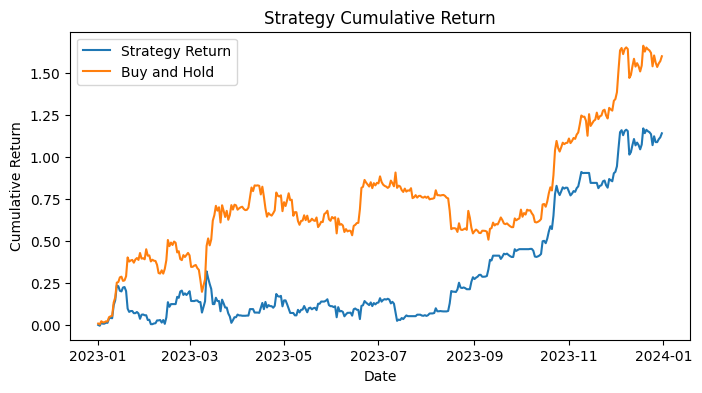

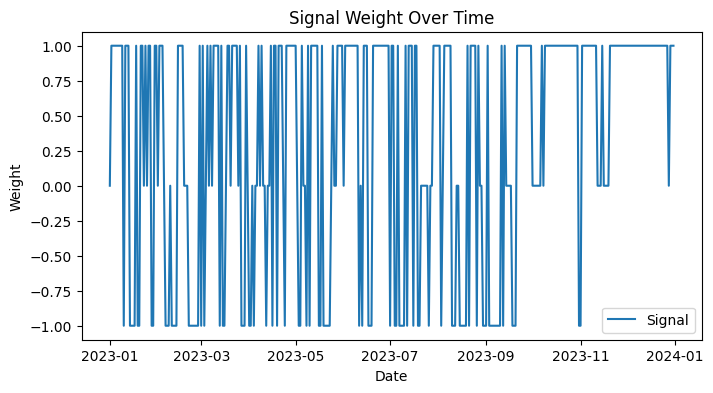

In [18]:
temp = pd.DataFrame()
temp["date"] = validation_data["date"]
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

rfr_bt = temp
rfr_bt['date'] = pd.to_datetime(rfr_bt['date'])

rfr_bt.set_index('date', inplace=True)

run_backtest(rfr_bt)

# XGB

In [19]:
xgb = XGBRegressor(random_state=42)


xgb.fit(X_train_smoothed, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
#Evaluate Model by Validation
y_pred_val = xgb.predict(X_val_smoothed)

mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')

Validation Set Metrics:
MSE: 0.714428
R-squared: -0.4415


In [21]:
y_train

0      1
1      0
2     -1
3      1
4      1
      ..
725    0
726    0
727    0
728    0
729    0
Name: target, Length: 730, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)


In [23]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)
grid_search.fit(X_train_smoothed, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)
best_xgb_reg = grid_search.best_estimator_


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}
Best Score (Negative MSE): -1.113292405945715


In [24]:
len(y_pred_val)

365

In [25]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = validation_data["date"]
x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)
xgb_bt

,Predicted return,signal
date,,
2023-01-01,-0.189868,-1
2023-01-02,0.425268,1
2023-01-03,-0.086416,-1
2023-01-04,0.220730,1
2023-01-05,0.792790,1
...,...,...
2023-12-27,0.064488,1
2023-12-28,0.464873,1
2023-12-29,-0.037066,-1


Overall Annual Return: 44.4%
Overall Annual Sharpe Ratio: 1.0145
Maximum Drawdown: -22.0 %
Alpha: 0.2738
Beta: 0.221

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.443956    0.470426     0.221023      0.242111       1.014499


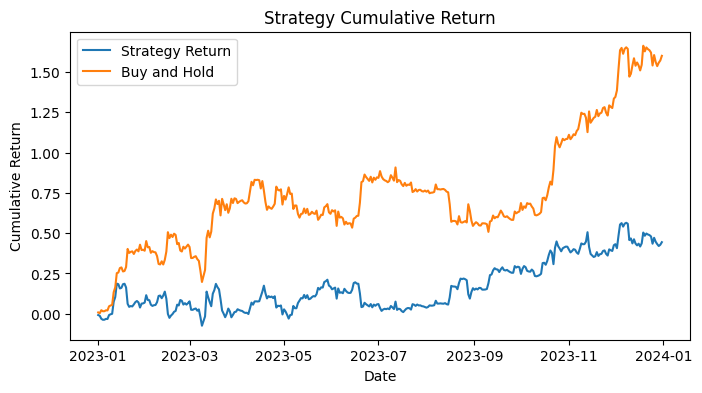

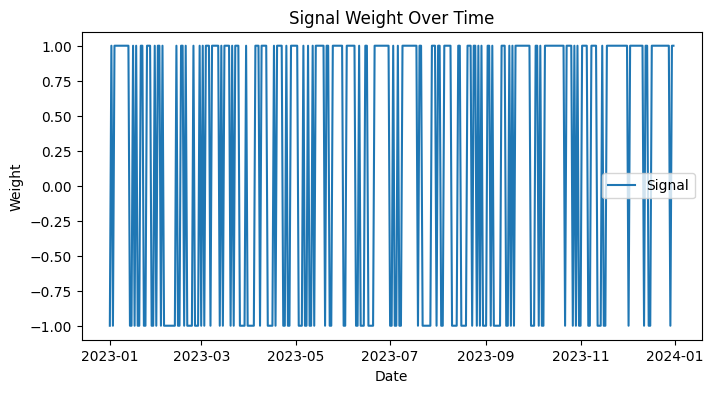

In [26]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = validation_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)


run_backtest(xgb_bt)



In [27]:
importances = best_xgb_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


               Feature  Importance
4       Sentiment_MA14    0.106480
2      regulation_absa    0.105727
8    Sentiment_MA7_ewm    0.105535
5   tanalysis_absa_ewm    0.104481
1         economy_absa    0.100188
7  regulation_absa_ewm    0.098803
9   Sentiment_MA14_ewm    0.097391
0       tanalysis_absa    0.094929
3        Sentiment_MA7    0.094422
6     economy_absa_ewm    0.092042


# Testing

# RFR

Overall Annual Return: 241.18%
Overall Annual Sharpe Ratio: 2.6551
Maximum Drawdown: -21.67 %
Alpha: 1.2204
Beta: 0.6137

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       2.411753    0.511872     0.613691      0.798537       2.655116


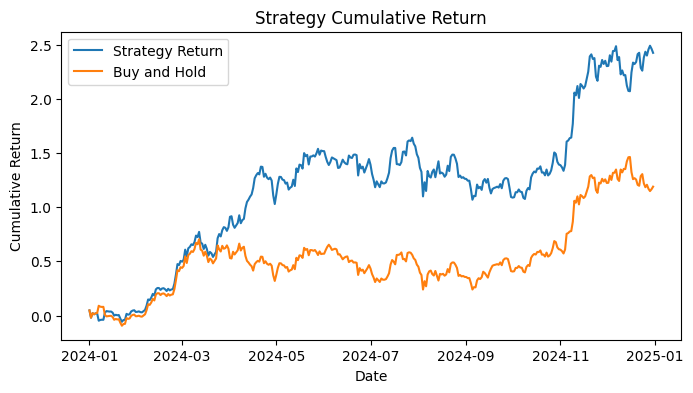

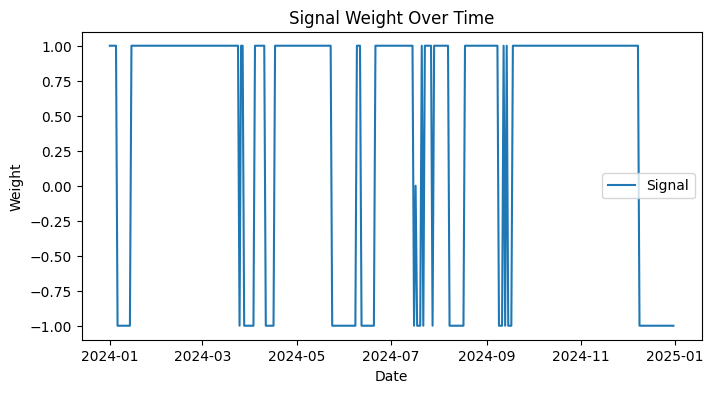

In [28]:
model = best_rf_reg

X_test_smoothed = X_test.copy()
numeric_columns = X_test_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_test_smoothed[f'{col}_ewm'] = X_test_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_test = model.predict(X_test_smoothed)


temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = test_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

rfr_bt_test = temp


rfr_bt_test.set_index('date', inplace=True)


run_backtest(rfr_bt_test)


In [29]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 1.527322
R-squared: -1.4528


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

data = test_data[(test_data['date'] >= test_startdate) & (test_data['date'] <= test_enddate)]
# btc_price["Open Time"] = pd.to_datetime(btc_price["Open Time"]).dt.date

btc = btc_price.loc["2024-01-01":"2024-12-31"]


x = pd.DataFrame()

x['signal'] = btc["return_forward"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# print(x.shape[0])
# print(data.shape[0])

# Assuming df1 and df2 are your two dataframes with a 'signal' column
# Ensure both dataframes are aligned (e.g., same index and sorted by date)
assert x.shape[0] == data.shape[0], "Dataframes must have the same number of rows"

# Extract the signal columns from both dataframes
true_signals = x['signal']  # Ground truth signals
predicted_signals = rfr_bt_test['signal']  # Predicted signals

# Calculate precision, recall, and F1 score
precision = precision_score(true_signals, predicted_signals, average='macro')
recall = recall_score(true_signals, predicted_signals, average='macro')
f1 = f1_score(true_signals, predicted_signals, average='macro')

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.35
Recall: 0.35
F1 Score: 0.33


In [31]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Test Set Metrics:
MSE: 1.527322
R-squared: -1.4528


# XGB

Overall Annual Return: 106.57%
Overall Annual Sharpe Ratio: 1.9003
Maximum Drawdown: -21.91 %
Alpha: 0.1975
Beta: 0.6981

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        1.06573    0.430412     0.698078      0.180285        1.90029


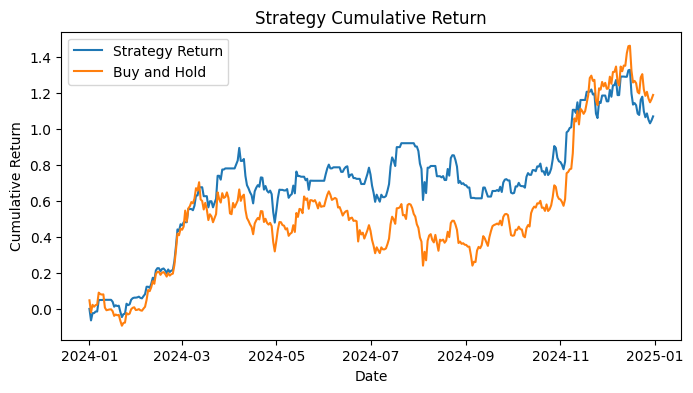

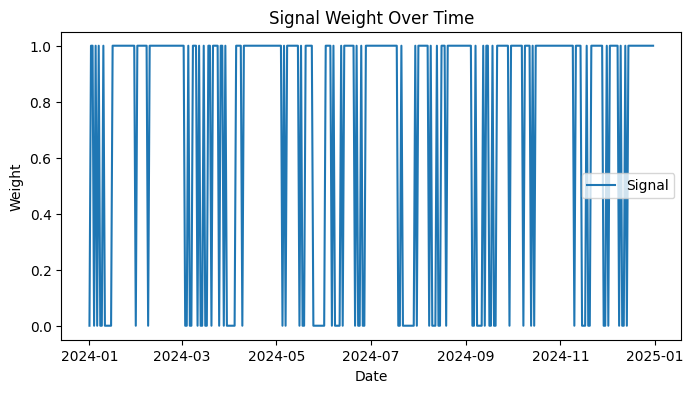

In [32]:
model = best_xgb_reg
y_pred_test = model.predict(X_test_smoothed)



temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = test_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt_test = temp


xgb_bt_test.set_index('date', inplace=True)


run_backtest(xgb_bt_test)

In [33]:
test_data


,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
1095,2024-01-01,-0.054651,-0.009302,0.043023,0.011628,0.239535,40.0,0.046047,0.092759,0.134411,0.152487,1
1096,2024-01-02,0.076444,0.014667,0.113778,0.028000,0.343556,40.0,0.115289,0.095189,0.139428,0.148765,-1
1097,2024-01-03,0.020532,-0.003422,0.028517,0.017490,0.228897,40.0,0.058403,0.073246,0.118886,0.144887,1
1098,2024-01-04,0.077626,-0.004566,0.005023,0.057078,0.398174,40.0,0.106667,0.093453,0.095098,0.140280,-1
1099,2024-01-05,0.006557,-0.003825,0.068852,0.057377,0.298907,40.0,0.085574,0.083548,0.092030,0.131789,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,1
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,-1
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

data = test_data[(test_data['date'] >= test_startdate) & (test_data['date'] <= test_enddate)]
btc = btc_price.loc["2024-01-01":"2024-12-31"]


x = pd.DataFrame()

# x['signal'] = btc["return_forward"]

x['signal'] = btc["return_forward"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# print(x.shape[0])
# print(data.shape[0])

# Assuming df1 and df2 are your two dataframes with a 'signal' column
# Ensure both dataframes are aligned (e.g., same index and sorted by date)
assert x.shape[0] == data.shape[0], "Dataframes must have the same number of rows"

# Extract the signal columns from both dataframes
true_signals = x['signal']  # Ground truth signals
predicted_signals = xgb_bt_test['signal']  # Predicted signals

# Calculate precision, recall, and F1 score
precision = precision_score(true_signals, predicted_signals, average='macro')
recall = recall_score(true_signals, predicted_signals, average='macro')
f1 = f1_score(true_signals, predicted_signals, average='macro')

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.18
Recall: 0.24
F1 Score: 0.20


In [35]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Test Set Metrics:
MSE: 1.234973
R-squared: -0.9833
